In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch
import copy
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

In [2]:
dtrain = pd.read_csv("synthetic_train.csv").to_numpy().astype(np.float32)
train_x, train_y = dtrain[:, 0:2], dtrain[:, 2:3]
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)

In [3]:
aa = list(range(len(dtrain)))
import random
random.shuffle(aa)
sample_idx = aa[0:500]
sample = dtrain[sample_idx]
sample_positive = sample[np.where(sample[:,2] == 0)]
sample_negative = sample[np.where(sample[:,2] == 1)]

In [4]:
h = 0.02
x_min, x_max = dtrain[:, 0].min() - .5, dtrain[:, 0].max() + .5
y_min, y_max = dtrain[:, 1].min() - .5, dtrain[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

In [5]:
dplot = np.c_[xx.ravel(), yy.ravel()]
_dplot = scaler.transform(dplot).astype(np.float32)
_dplot = torch.from_numpy(_dplot)

In [6]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    model.train()
    prediction = []
    label = []

    for batch_idx, (data, target) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.round(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        label.extend(target.tolist())
        prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    model.eval()
    prediction = []
    label = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(iterator):

            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            preds = torch.round(output)
            loss = criterion(output, target)
            epoch_loss += loss.item() * len(target)
            label.extend(target.tolist())
            prediction.extend(preds.reshape(-1).tolist())
            
    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1


In [7]:
Train = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(Train, batch_size  = 128)

0
1
2
3


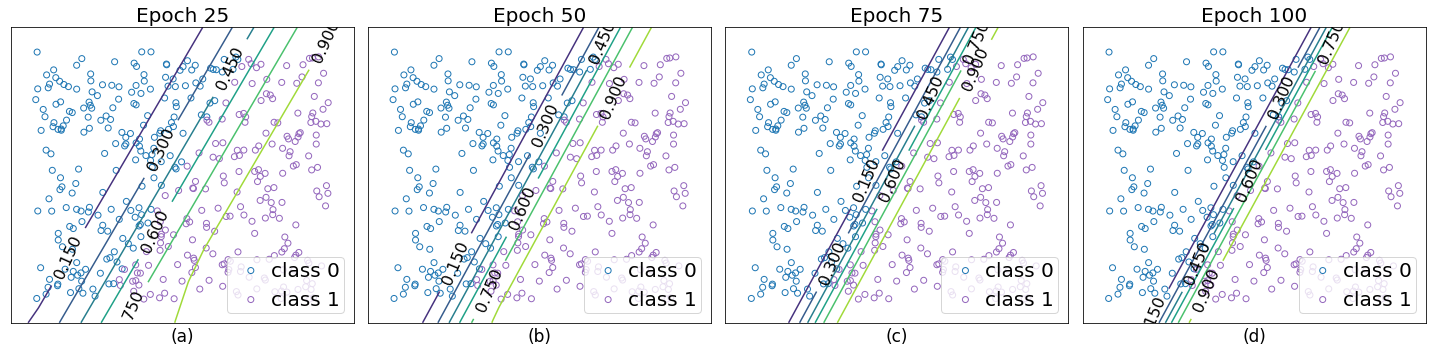

In [17]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)

optimizer = optim.Adam(model.parameters(), lr = 0.003)
criterion = nn.BCELoss()
device = torch.device("cpu")
model = model.to(device)
criterion = criterion.to(device)


fig, axs = plt.subplots(1, 4)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['xtick.labelsize']= 17
plt.rcParams['ytick.labelsize']= 17
plt.rcParams["figure.figsize"] = (20, 5)

best_f1 = -float('inf')
best_model = None
best_acc = -float('inf')

for epoch in range(100):

    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, device)

    #print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
    if (epoch + 1) % 25 == 0:
        fig_idx = int((epoch + 1) / 25 - 1)
        print(fig_idx)
        S = model(_dplot).detach().numpy()
        S = S.reshape(xx.shape)
        axs[fig_idx].tick_params(axis='both', which='major', labelsize=12)
#         fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(5, 5)
        #matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
        CS = axs[fig_idx].contour(xx, yy, S, linewidths = 1.5)
        
        if epoch > 50:
            axs[fig_idx].clabel(CS, fontsize= 16, inline=1, colors = 'black')
        else:
            axs[fig_idx].clabel(CS, fontsize= 16, inline=1, colors = 'black')
            
        #ax.scatter(sample_positive[:, 0], sample_positive[:, 1], c = '#1f77b4', label = "class 0")
        #ax.scatter(sample_negative[:, 0], sample_negative[:, 1],c = '#9467bd', label = "class 1")
        axs[fig_idx].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
        axs[fig_idx].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
        axs[fig_idx].set_xticks([])
        axs[fig_idx].set_yticks([])
        axs[fig_idx].legend(loc = 'lower right', fontsize = 20, handletextpad = 0, columnspacing = 0, borderpad = 0.2)
        axs[fig_idx].set_title("Epoch {}".format(epoch + 1), fontsize = 20)
        
axs[0].set_xlabel("(a)", fontsize = 17)
axs[1].set_xlabel("(b)", fontsize = 17)
axs[2].set_xlabel("(c)", fontsize = 17)
axs[3].set_xlabel("(d)", fontsize = 17)
save_name = "synthetic_{}.pdf".format(epoch + 1)
plt.tight_layout()
plt.savefig(save_name, dpi = 600, bbox_inches = 'tight')
plt.show()


In [ ]:
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].set_xticks([])
axs[3].set_yticks([])